In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torch import tensor

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
import zipfile

# Replace 'path_to_your_dataset' with the actual path where your dataset is stored
zip_path = '/content/drive/My Drive/clocks_dataset.zip'
extract_path = '/content/clocks_dataset/train'

os.makedirs(extract_path, exist_ok=True)

# Unzipping the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

A clockdataset class is defined by inherriting Dataset, this inheritance requires implementing of len() and getitem() methods. first a constructer init is defined where the path of the directory and sequence of transformations is inputted, the constructer intializes the clockdataset with this directory and transformations, then a variable that holds a list of the images files paths in the directory is created, this list is a filtered list of file paths that ends with .png extension as this is the images extension. the len function returns the number of images files that were extracted. the getitem function takes the index of the requested item as an input, it then access the path of the requested image and used Image module from PIL library to load it, if a sequence of transformations were supplied, the transformation is applied to the requested image and then the image is retured. this dataset only works with images as labels are not really needed as just images are generated its not a classification or regression problem.

In [7]:
class ClockDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        # Correctly name the attribute
        self.image_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]  # Use the correct attribute name here

        image = Image.open(img_path)


        if self.transform:
            image = self.transform(image)

        return image

the transformations sequence is defined, with photos being resized from dimensions (448,448) to (64,64), this is done to help with the complexity of the model and number of weights, also photos with this dimensions are clear enough and indicative of the features of the clocks. ToTensor transformation is used to first scale the pixel values into the range of 0 to 1, and then convert the images into tensors. the training dataset is initialized with the path of the directory which holds the images files and with the sequence of transformations. only a training set is needed as GANs are an unsupervised models, so there is not right answers or labels to validate against.

In [8]:
transform = transforms.Compose([


    transforms.Resize((64,64)),
    transforms.ToTensor(),
    # transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    # transforms.RandomRotation(degrees=(-10, 10))
    # transforms.RandomHorizontalFlip(p=0.3),

    # transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)
    # transforms.RandomResizedCrop(size=32, scale=(0.4, 1.0), ratio=(1.0, 1.0))



])

clock_dataset = ClockDataset(directory=extract_path, transform=transform)



print(len(clock_dataset))


10000


Dataloader for training is set up using Dataloader class with batchsize set to 100 that is the size of the batch got from the dataset during training. at every epoch the data is shuffled to not make the model used to a particular order. then the device is set to use a GPU if it is avaiable.

In [11]:
train_loader = DataLoader(clock_dataset, batch_size=100, shuffle=True, num_workers=1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
image =clock_dataset[0]
print(image.shape)

torch.Size([3, 64, 64])


In [13]:
images= next(iter(train_loader))
print(images.shape)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([100, 3, 64, 64])


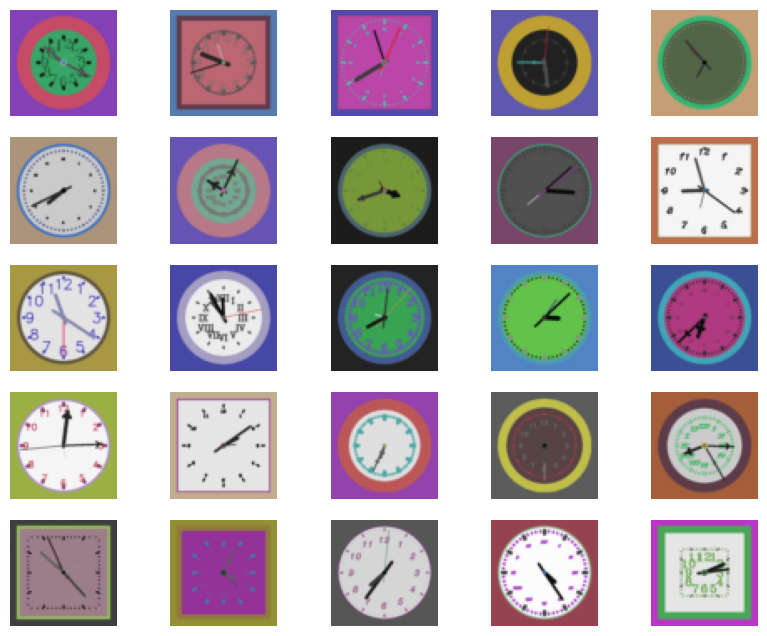

In [14]:
images = next(iter(train_loader))

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(cols * rows):
    # img = images[i].permute(1, 2, 0)  # Reorder dimensions for displaying
    # img = img.clamp(0, 1)  # Clamp to make the img range [0, 1]
    figure.add_subplot(rows, cols, i+1)
    plt.axis("off")
    plt.imshow(images[i].permute(1, 2, 0))
plt.show()

nz is the size of the input given to the generator, the input is a randomly sampled vector from the latent space. ngf is the size of the feature maps in the generator architecture. ndf is the size of the feature maps in the discriminator architecture. number of epochs specify how long will the the network train, it is set to 60 to balance between learning the patterns and capturing it but without leading to overfitting. lr is the learning rate for both the generator optimizer and the discriminator optimizer. it is set to 0.0002 as its not high that will lead the training to be unpredictable and diverge, and its not too low to make the convergence speed very slow and maybe result in getting stuck in local minimas, also this is the learning rate that was used in DCGAN architecture that proved it works well. beta1 controls the exponential decay rate for the moving average of the gradients in Adam optimizers, a low value is chosen to make Adam adapts more quickly to the changes that happens in the training.

In [16]:
batch_size = 100
nz = 100 # Size of z latent vector (i.e. size of generator input)
ngf = 128 # Size of feature maps in generator
ndf = 128 # Size of feature maps in discriminator
num_epochs = 60 # Number of training epochs
lr = 0.0002 # Learning rate for optimizers
beta1 = 0.5 # Beta1 hyperparam for Adam optimizers

the generator architecture is defined, the first layer is a transposed convolutional layer which takes an input of size nz which is the size of the latent vector. transposed convolutional layer is used to increase the spatial dimension, stride is set to 1 to ensure there is nothing skipped because every detail is important. batch normalization is used to normalize the output of the convolutional layer to help with the training, ReLU is used to introduce non linearity to the model in order to capture non linear patterns. the first layer expands the input into a higher dimensional space to upsample it and increase the dimensions of the feature maps. the next layers convolutional layer, the number of outputs are decreased as the aim is to keep the relevant details. also the stride is increased to 2 this result in doubling of the spatial dimensions as this is a transposed convolutional layer. After the last convolutional layer, tanh is used to scale the pixels intensity to a range of 1 to -1., generator is then initialized.

In [17]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z of size B x nz x 1 x 1, we put this directly into a transposed convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf, 3, 4, 2, 1, bias=False),

            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

netG = Generator()
netG = netG.to(device)

Discriminator is a CNN that does binary classification to classify images to real or fake, the discriminator architecture are made up of multiple convolutional layers that downsample the input image which is made up of 3 channels because it is an RGB image, this is done to extract the essential features to be able to diffrenciate between real and fake. in the first layer the stride is set to 2 to decrese the spatial dimensions by half as this is a regular convolutinal layer. the rest of the convultional layers doubles its input to increase the complexity of the model and its ability to capture complicated features. the stride is set to two also in the rest of the layers to continue in downsampling and reducing the spatial dimensions. following every convolutinal layer, there is a batch normalisation layer and leaky ReLU, batch normalization is used to normalize the layers outputs and also to fight overfitting in order to have a stable training process, LeakyReLU is used to introduce non-linearity, the difference between leakyReLU and ReLU is that the negative values of the gradients are allowed to leak, this ensures that there is no waste in gradient's information. the output of the last convolutional layer is 1 which represents the probability whether this image is real or fake, the sigmoid is used to map the output to the range of 0 and 1 to represent the probability.

In [18]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(

            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

netD = Discriminator()
netD = netD.to(device)

 Binary Cross Entropy loss is used as the criterion to measure the the difference between the probability distribution of the labels predicted by the discriminator and the probability distributions of the actual labels. BCE is choosen as it the most commonly used. criterion in binary classification tasks. then the convention for real and fake labels during training is established, then optimizers for both generator and discriminator with the learning rate and beta specified earlier, then the training loop starts with iterating over every epochs, and for every image in the train loader, the gradients are first cleared out, the discriminator training is started, then the batch for images and labels is formatted, then the real images are passed into the discriminator, the loss is then calculated between the output and the true labels, then the gradient of this error is computed, then fake data is generated using the generator and passed into the discriminator, then the loss is computed between the predicted and the actuals, and gradient of this loss is backpropagated. after computed the two losses for real and fake images, the losses are summed and the model is updated based on the gradient.

 the generator training then begins, the generator is updated twice with each discriminator update to balance the power between the discriminator and generator in the training process to stablize the training and make sure that both components are learning effectively without one network dominating the other. first the gradients of the generator are cleared, then new fake pictures are generated by the generator, then the discriminator is given these fake images but with real labels to fool it. the loss is computed betwene the prediction of discriminator and actuals, then the loss is backpropagated to the generator to update its weights,

In [19]:
criterion = nn.BCELoss()

real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(netD.parameters(),lr = lr, betas =(beta1,0.999))
optimizerG = optim.Adam(netG.parameters(),lr =lr, betas =(beta1,0.999))

print("Starting Training Loop...")

for epoch in range(num_epochs):

  for i, images in enumerate(train_loader,0):

    netD.zero_grad()

    real_images = images.to(device)
    label = torch.full((batch_size,),real_label, dtype = torch.float, device = device)

    output = netD(real_images).view(-1)

    errD_real = criterion(output, label)

    errD_real.backward()

    D_x = output.mean().item()

    z = torch.randn(batch_size, nz, 1 ,1 , device = device)

    fake = netG(z)
    label.fill_(fake_label)

    output = netD(fake.detach()).view(-1)

    errD_fake = criterion(output, label)

    errD_fake.backward()

    D_G_z1 = output.mean().item()

    errD = errD_real + errD_fake

    optimizerD.step()

    # generator
    for _ in range(2):

      netG.zero_grad()
      z = torch.randn(batch_size, nz, 1 ,1 , device = device)
      fake_image =  netG(z)
      label.fill_(real_label)
      output = netD(fake_image).view(-1)

      errG = criterion(output, label)

      errG.backward()

      D_G_z2 = output.mean().item()

      optimizerG.step()

    if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, i, len(train_loader),
                    errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))



Starting Training Loop...
[1/60][0/100]	Loss_D: 1.3862	Loss_G: 0.0505	D(x): 0.4948	D(G(z)): 0.4780 / 0.9511
[1/60][50/100]	Loss_D: 4.7949	Loss_G: 23.5410	D(x): 0.9998	D(G(z)): 0.9913 / 0.0000
[2/60][0/100]	Loss_D: 2.1602	Loss_G: 0.8161	D(x): 0.1580	D(G(z)): 0.0336 / 0.4467
[2/60][50/100]	Loss_D: 1.8544	Loss_G: 5.6231	D(x): 0.8803	D(G(z)): 0.8109 / 0.0040
[3/60][0/100]	Loss_D: 0.9257	Loss_G: 1.5767	D(x): 0.6103	D(G(z)): 0.2946 / 0.2367
[3/60][50/100]	Loss_D: 1.4328	Loss_G: 3.7366	D(x): 0.8488	D(G(z)): 0.6910 / 0.0313
[4/60][0/100]	Loss_D: 1.0823	Loss_G: 1.5254	D(x): 0.5831	D(G(z)): 0.3724 / 0.2278
[4/60][50/100]	Loss_D: 1.6111	Loss_G: 1.3422	D(x): 0.2715	D(G(z)): 0.0464 / 0.2867
[5/60][0/100]	Loss_D: 0.8670	Loss_G: 1.8243	D(x): 0.5360	D(G(z)): 0.1136 / 0.1871
[5/60][50/100]	Loss_D: 0.9424	Loss_G: 1.6267	D(x): 0.4832	D(G(z)): 0.0880 / 0.2125
[6/60][0/100]	Loss_D: 1.0677	Loss_G: 2.1198	D(x): 0.7909	D(G(z)): 0.5373 / 0.1319
[6/60][50/100]	Loss_D: 0.9982	Loss_G: 2.1278	D(x): 0.6399	D(G(z)):

a batch of 8 random noise vectors is genarted, this noise vector is used by the generator to generate a batch of 8 pictures, the pictures are visualised. the image tensor is moved to cpu, then detatched from the computation graph, and then the order of its dimensions is changed to match the order of dimensions expected by plt.imshow

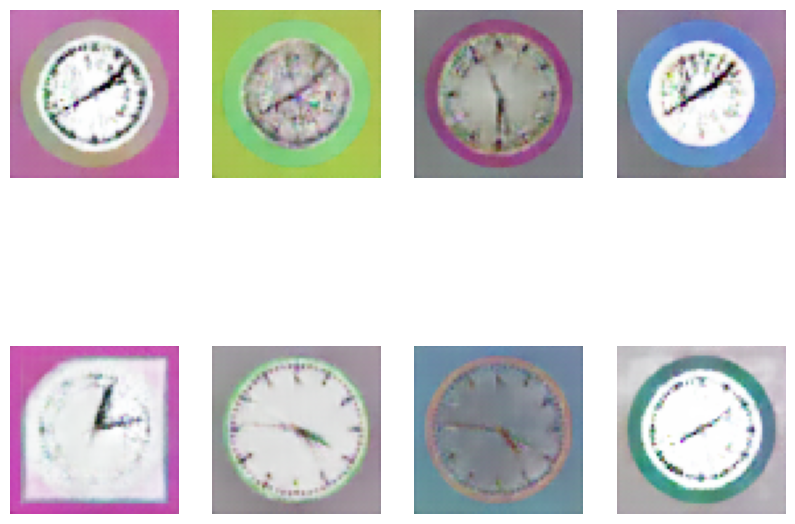

In [20]:
z = torch.randn(8,nz,1,1,device=device)
images = netG(z)

figure = plt.figure(figsize=(10, 8))
cols, rows = 4, 2
for i in range(cols * rows):
    figure.add_subplot(rows, cols, i+1)
    plt.axis("off")
    img = images[i].cpu().detach().permute(1, 2, 0)
    img = torch.clamp(img, 0, 1)
    plt.imshow(img)
plt.show()





two random latent spaces are generated, then a tensor is initialized to store the interpolated vectors, then a loop is created to linearly interplorate between the latent spaces by having weights that change throughout loop iterations, making it in the middle itertaion to create a blend between the two latent spaces, the interpolated latent vectors are passed to the generator, and the genrated 7 pictures are plotted.

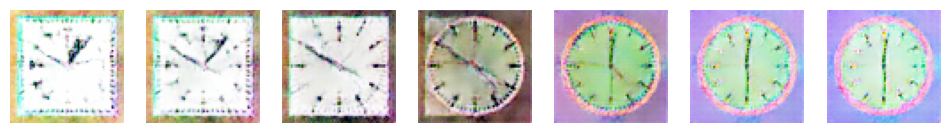

In [22]:
nsamples = 7
z1 = torch.randn(1,nz,1,1, device = device)
z2 = torch.randn(1,nz,1,1,device = device)
z = torch.zeros(nsamples,nz,1,1,device = device)

for i in range(nsamples):
  w1 = i/(nsamples-1)
  w2 = 1 -w1
  z[i,:,:,:]= w1 * z1 + w2 * z2

images = netG(z)

figure = plt.figure(figsize =(12, 4))
for i in range(nsamples):
  figure.add_subplot(1, nsamples, i+1)
  plt.axis("off")
  img = images[i].cpu().detach().permute(1,2,0)
  img = torch.clamp(img, 0, 1)
  plt.imshow(img)
plt.show()

